In [175]:
import os
import time
import pickle
import torch
import torch.nn as nn
import numpy as np
import scipy
from scipy import special, integrate, optimize, stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
def tail_Gaussian_abs(x):
    return 1 - torch.erf(x/np.sqrt(2))

def compute_Linf_error_v2(t_x, t_tail, f_target):
    fy = f_target(t_x)
    #print(t_x[(t_tail - fy).abs().argmax()])
    return (t_tail - fy).abs().max()

In [16]:
class ParameterizedFunction(torch.nn.Module):
    """
    theta: parameter of the Weibull distribution
    1/2 = 1/theta + 1/theta_conj
    f(x) = gamma * alpha / lambda_1^alpha x^(alpha - 1) exp(-(x / lambda_1^)alpha) + sqrt(2/pi) 1/Gamma(1 - 1/theta) exp(-(x/lambda_2)^theta_conj)
    """
    def __init__(self, theta, theta_conj, alpha, lambd_1, lambd_2, gamma):
        super(ParameterizedFunction, self).__init__()
        self.register_buffer('theta', torch.tensor(theta))
        self.register_buffer('theta_conj', torch.tensor(theta_conj))
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.lambd_1 = nn.Parameter(torch.tensor(lambd_1))
        self.lambd_2 = nn.Parameter(torch.tensor(lambd_2))
        self.gamma = nn.Parameter(torch.tensor(gamma))

    def get_support(self): # TODO : to check
        sigma_1 = np.sqrt(self.lambd_1.pow(2).item() * special.gamma(1 + 1/self.theta_conj.item()))
        sigma_2 = np.sqrt(self.lambd_2.pow(2).item() * special.gamma(1 + 1/self.theta_conj.item()))
        return (0., 3 * (sigma_1 + sigma_2))

    def term_peak(self, x):
        a1 = self.gamma * (self.alpha / torch.pow(self.lambd_1, self.alpha)) \
                * torch.pow(x, self.alpha - 1) * torch.exp(-torch.pow(x / self.lambd_1, self.alpha))
        return a1

    def term_bounds(self, x):
        return np.sqrt(2/np.pi) * torch.exp(- torch.pow(x / self.lambd_2, self.theta_conj)) \
                / special.gamma(1 - 1/self.theta)

    def forward(self, x):
        return self.term_peak(x) + self.term_bounds(x)

In [287]:
class Integrand(torch.nn.Module):
    def __init__(self, density, tail_kernel):
        super(Integrand, self).__init__()

        self.density = density
        self.tail_kernel = tail_kernel
        
    def compute_intervals(self, z, a, b, num_intervals):
        f = lambda x: self.tail_kernel(z, x) * self.density(x)
        
        scipy_result = integrate.quad(f, a, b, epsabs = 1e-4, epsrel = 1e-4, full_output = 1)
        scipy_num_intervals = scipy_result[2]['last']
        left_pts = sorted(scipy_result[2]['alist'][:scipy_num_intervals])
        right_pts = sorted(scipy_result[2]['blist'][:scipy_num_intervals])

        intervals = [torch.linspace(l, r, num_intervals) for l, r in zip(left_pts, right_pts)]
        dxs = [inter[1] - inter[0] for inter in intervals]

        return intervals, dxs

    def integrate(self, z, intervals, dxs):
        f = lambda x: self.tail_kernel(z, x) * self.density(x)
        return torch_integrate(f, intervals, dxs)
    
    """def integrate_scipy(self, z, a, b, eps = 1e-10, num_intervals = 100):
        support = self.density.get_support()
        f = lambda x: self.tail_kernel(z, x) * self.density(x)
        return torch_integrate_scipy(f, a, b, support, eps, num_intervals)"""
    
    def integrate_scipy(self, z, a, b):
        f = lambda x: self.tail_kernel(z, x) * self.density(x)
        
        return integrate.quad(f, a, b)[0]

    def get_f(self):
        def f(x):
            with torch.no_grad():
                return self.forward(x)
        return f

    def forward(self, x):
        if isinstance(x, (int, float, list)):
            x = torch.tensor(x, dtype = torch.float)

        return self.approx_mod(x) * self.kernel(self.z, x)

In [288]:
def torch_integrate(f, intervals, dxs):
    torch_res = 0
    for inter, dx in zip(intervals, dxs):
        torch_res += torch.trapezoid(f(inter), dx = dx)
        
    return torch_res

In [289]:
def torch_integrate_scipy(f, a, b, support, eps, num_intervals):
    scipy_result = integrate.quad(f, a, b, epsabs = 1e-4, epsrel = 1e-4, full_output=1, limit = 20)
    scipy_num_intervals = scipy_result[2]['last']
    left_pts = sorted(scipy_result[2]['alist'][:scipy_num_intervals])
    right_pts = sorted(scipy_result[2]['blist'][:scipy_num_intervals])
    
    torch_res = 0
    for l, r in zip(left_pts, right_pts):
        #print(l, r)
        inter_x = torch.linspace(l, r, num_intervals)
        dx = inter_x[1] - inter_x[0]
        torch_res += torch.trapezoid(f(inter_x), dx = dx)
    
    """print('scipy_result: ', scipy_result[0])
    print('error: ', scipy_result[0] - torch_res.item())"""
        
    return torch_res, scipy_result[0] - torch_res.item()

In [290]:
def build_kernelWeib(theta, lambd):
    def kernelWeib(z, y):
        return np.exp(-np.power((z/y)/lambd, theta))
    return kernelWeib

In [291]:
theta = 4.
lambd = 1.
theta_conj = 1/(1/2 - 1/theta)
alpha = 3.
lambd_1 = 1.
lambd_2 = 1.
gamma = 1.

tail_kernel = build_kernelWeib(theta, lambd)

density = ParameterizedFunction(theta, theta_conj, alpha, lambd_1, lambd_2, gamma)
integrand = Integrand(density, tail_kernel)

In [292]:
z = .01

intervals, dxs = integrand.compute_intervals(z, 0, 10, 15)
print(integrand.integrate(z, intervals, dxs))
print(integrand.integrate_scipy(z, 0, 10, num_intervals = 15))

tensor(1.5832, grad_fn=<AddBackward0>)


TypeError: Integrand.integrate_scipy() got an unexpected keyword argument 'num_intervals'

In [311]:
z = 1

print('true: ', integrand.integrate_scipy(z, 0, np.inf))

intervals, dxs = integrand.compute_intervals(z, 0, 10, 50)
print(integrand.integrate(z, intervals, dxs))

intervals, dxs = integrand.compute_intervals(z, 0, 1000, 15)
print(integrand.integrate(z, intervals, dxs))

true:  0.31980592816138287
tensor(0.3198, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<AddBackward0>)


In [328]:
def find_density_cfg4c(theta, err, zmin, zmax, znum, lambd = 1., \
                     lr = .001, epochs = 100):
    # Training data
    tail_kernel = build_kernelWeib(theta, lambd)
    inputs = torch.linspace(zmin, zmax, znum)
    targets = tail_Gaussian_abs(inputs)
    
    # Init model
    theta_conj = 1/(1/2 - 1/theta)
    alpha = 3.
    lambd_1 = 1.
    lambd_2 = 1.
    gamma = 1.

    density = ParameterizedFunction(theta, theta_conj, alpha, lambd_1, lambd_2, gamma)
    integrand = Integrand(density, tail_kernel)
    
    inter_update_period = 50
    
    """lst_thetas_conj1 = np.linspace(2., theta_conj, epochs // 2)
    lst_thetas_conj2 = np.array([theta_conj] * (epochs - epochs // 2))
    lst_thetas_conj = np.concatenate((lst_thetas_conj1, lst_thetas_conj2))"""
    epochs1 = epochs // 3
    epochs2 = 2 * epochs // 3
    lst_thetas_conj1 = np.array([2.] * epochs1)
    lst_thetas_conj2 = np.linspace(2., theta_conj, epochs2 - epochs1)
    lst_thetas_conj3 = np.array([theta_conj] * (epochs - epochs2))
    lst_thetas_conj = np.concatenate((lst_thetas_conj1, lst_thetas_conj2, lst_thetas_conj3))
    
    # Training
    optimizer = torch.optim.Adam(density.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
        factor = np.power(.1, 1/3), patience = 20, threshold = .01, cooldown = 20)
    
    lst_intervals = [None] * len(inputs)
    lst_dxs = [None] * len(inputs)
    for epoch in range(epochs):
        if epoch % inter_update_period == 0:
            for i, z in enumerate(inputs):
                lst_intervals[i], lst_dxs[i] = integrand.compute_intervals(z, 0, 10, 50)
                
        if epoch == epochs1 or epoch == epochs2:
            optimizer = torch.optim.Adam(density.parameters(), lr = lr)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
                factor = np.power(.1, 1/3), patience = 20, threshold = .01, cooldown = 20)
        
        density.theta_conj.data = torch.tensor(lst_thetas_conj[epoch])
        #print('theta_conj: ', density.theta_conj.data)
        
        optimizer.zero_grad()

        lst_y = torch.empty(len(inputs))
        for i, z in enumerate(inputs):
            if i == 0:
                lst_y[i] = 1
            else:
                lst_y[i] = integrand.integrate(z, lst_intervals[i], lst_dxs[i])
                #lst_y[i] = integrand.integrate(z, 0., 1000, num_intervals = 15)[0]

        loss = compute_Linf_error_v2(inputs, lst_y, tail_Gaussian_abs)
        loss.backward()
        
        for n, t in density.named_parameters():
            if t.grad is not None and torch.isnan(t.grad):
                t.grad.zero_()
        
        optimizer.step()
        scheduler.step(loss)
        
        if epoch % 50 == 0 or epoch == epochs - 1:
            print('    epoch {} ; loss: {:.6f}'.format(epoch, loss.item()))
        #print('lst_y = {}'.format(lst_y))
        """for n, t in density.named_parameters():
            print('{} = {:.6f}'.format(n, t.item()))"""
        #print('epoch: ', epoch, '; loss: ', loss.item())
        
    return density, loss.item()

In [344]:
# Solve integral equation
restart = False
cfg = 'cfg4c'
path_store = './'

zmin = 0
zmax = 5
znum = 200
max_err = .015

lr = .01
epochs = 600

fs_name = 'InvInt_dens_' + cfg + '_theta-{:.4f}_err-{:.2e}_zmin-{:.2e}_zmax-{:.2e}_znum-{}_.pkl'
func_cfg = globals()['find_density_' + cfg]
lst_theta = [4.] #[2.05, 2.1, 2.2, 2.5, 3., 4., 5., 6., 7., 8., 9., 10.]

dct_f_approx = {}

for theta in lst_theta:
    dct_densities[theta], err = func_cfg(theta, max_err, zmin, zmax, znum, lr = lr, epochs = epochs)

    """pickle.dump({'approx': approx, 'err': err}, \
        file = open(path_store + fs_density_func.build_fname(theta, err, zmin, zmax, znum), 'wb'))"""

    epoch 0 ; loss: 0.577068
    epoch 50 ; loss: 0.095404
    epoch 100 ; loss: 0.004507
    epoch 150 ; loss: 0.002852
    epoch 200 ; loss: 0.002652
    epoch 250 ; loss: 0.004945
    epoch 300 ; loss: 0.006938
    epoch 350 ; loss: 0.008153
    epoch 400 ; loss: 0.009657
    epoch 450 ; loss: 0.009589
    epoch 500 ; loss: 0.008657
    epoch 550 ; loss: 0.008072
    epoch 599 ; loss: 0.008005


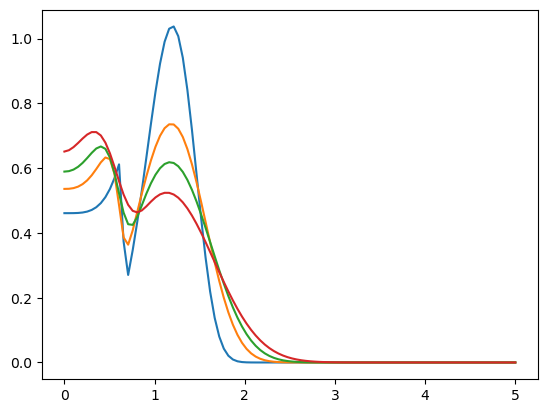

In [345]:
with torch.no_grad():
    plt.plot(np.linspace(0, 5, 100), dct_densities[2.05](torch.linspace(0, 5, 100)))
    plt.plot(np.linspace(0, 5, 100), dct_densities[2.5](torch.linspace(0, 5, 100)))
    plt.plot(np.linspace(0, 5, 100), dct_densities[3.](torch.linspace(0, 5, 100)))
    plt.plot(np.linspace(0, 5, 100), dct_densities[4.](torch.linspace(0, 5, 100)))

In [346]:
pickle.dump(dct_densities, open('dct_densities.pkl', 'wb'))

In [7]:
def torch_integrate_old(mod_f, a, b, support, eps = 1e-10, num_intervals = 100):
    def f(x):
        with torch.no_grad():
            return mod_f(x)

    def find_a_b(a_, b_):
        supp_min = float(support[0]) #torch.tensor(support[0], dtype = torch.float)
        supp_max = float(support[1]) #torch.tensor(support[1], dtype = torch.float)

        if supp_min < a_:
            supp_min = a_
        if supp_max > b_:
            supp_max = b_

        if f(supp_max) <= eps:
            b_ = supp_max
        elif b_ > supp_max:
            curr_b = supp_max
            if b_ == np.inf:
                while f(curr_b) >= eps:
                    curr_b *= 10
                    if curr_b > 1e20:
                        raise ValueError('f does not decrease quickly enough.')
                b_ = optimize.brentq(lambda x: f(x) - eps, supp_max, curr_b)
            else:
                while curr_b < b_:
                    if f(curr_b) >= eps:
                        curr_b *= 10
                    else:
                        b_ = optimize.brentq(lambda x: f(x) - eps, supp_max, curr_b)
                        break
        if f(supp_min) <= eps:
            a_ = supp_min
        elif 0 < supp_min and f(eps) < eps:
            curr_a = supp_min

            while curr_a > a_:
                if f(curr_a) >= eps:
                    curr_a /= 10
                else:
                    a_ = optimize.brentq(lambda x: f(x) - eps, curr_a, supp_min)
                    break

        return a_, b_, supp_min, supp_max

    a, b, supp_min, supp_max = find_a_b(a, b)

    result = None
    if a != supp_min:
        inter_x = torch.tensor(np.linspace(a, supp_min, num_intervals), dtype = torch.float)
        dx = inter_x[1] - inter_x[0]
        res = torch.trapezoid(mod_f(inter_x), dx = dx)
        if result is None:
            result = res
        else:
            result += res

    if supp_min != supp_max:
        inter_x = torch.tensor(np.linspace(supp_min, supp_max, num_intervals), dtype = torch.float)
        dx = inter_x[1] - inter_x[0]
        res = torch.trapezoid(mod_f(inter_x), dx = dx)
        if result is None:
            result = res
        else:
            result += res

    if supp_max != b:
        inter_x = torch.tensor(np.linspace(supp_max, b, num_intervals), dtype = torch.float)
        dx = inter_x[1] - inter_x[0]
        res = torch.trapezoid(mod_f(inter_x), dx = dx)
        if result is None:
            result = res
        else:
            result += res

    return result